In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
import glob
import time
import arrow
import pickle

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## annotation:

We visualise (all for 1st day of all 12 months):
    - u velocities 
    - present-day boundary conditions 
    - the old intrusion (present-day - old BC's)
    - the new intrusion (present day - new BC's) - smaller especially at depth 
    (at sigma <25 we have assigned it the number 50 for now)
    - new intrusion - old intrusion (difference between old PI boundary conditions and new ones)

In [3]:
##define areas in m2 of each cell on the boundary:boundary starts at 375

w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(w['e2t'][0,375:470,10])
boundary_ys = w['e2t'][0,375:470,10]
depths = w['gdept_1d'][:]
#print(w['e3t_1d'][0])
area = np.zeros([40,95])
ydir = np.zeros([40,95])
zdir = np.zeros([40,95])
for i in range(0,40):
    zdir[i,:]=w['e3t_1d'][0,i]
for i in range(0,95):
    ydir[:,i]=boundary_ys[i]
    
area = ydir * zdir

w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
mask_bdy = w['umask'][0,:,375:470,10]

In [4]:
start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)
    



### extract U velocities and transports at 10 gridcells from boundary and also sigma0 of the BCs 

In [5]:
# ## define 12 U velocity files for 12 days throughout the year > get transports
# days = ['0101','0201','0301','0401','0501','0601','0701','0801','0901','1001','1101','1201']
# #w1 = nc.Dataset(f'/data/tjarniko/results/BASERUN_EXP/PI5/ncs/{tf}')
# day1ofmonth_velocities_PI5 = np.zeros([365,40,95])
# day1ofmonth_transports_PI5 = np.zeros([365,40,95])
# ### get 

# s = time.time()
# for i in range(0,365):
#     if i%50==0:
#         print(i)
#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     #print(ymd)
#     w = f'/data/tjarniko/results/BASERUN_EXP/PI5/ncs/SKOG_1d_*_grid_U_*{ymd}.nc'
#     w2 = glob.glob(w)
#     #print(w2)
#     tdat = nc.Dataset(w2[0])
#     UVEL = tdat['vozocrtx']
    
#     UVEL_jdfmouth = UVEL[0,:,375:470,10]
#     UTR_M3_s = UVEL_jdfmouth*area
#     day1ofmonth_velocities_PI5[i,:,:] = UVEL_jdfmouth
#     day1ofmonth_transports_PI5[i,:,:] = UVEL_jdfmouth * area 
    
#     day1ofmonth_velocities_PI5[day1ofmonth_velocities_PI5==0] = np.nan
#     day1ofmonth_transports_PI5[day1ofmonth_transports_PI5==0] = np.nan

In [6]:
# pickle.dump(day1ofmonth_velocities_PI5, open("./pkls/day1ofmonth_velocities_PI5.pkl", 'wb'))
# pickle.dump(day1ofmonth_transports_PI5, open("./pkls/day1ofmonth_transports_PI5.pkl", 'wb'))

# #hindcast2008_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2008_wind_mag.pkl', 'rb'))  


In [7]:
# ### get sigma

# preind_sigma = np.zeros([365,40,95])

# tm = ['01','02','03','04','05','06','07','08','09','10','11','12']

# for i in range(0,365):
#     tdate = arrow_array[i][0]
#     yy = tdate.format('YYYY')
#     mm = tdate.format('MM')
#     dd = tdate.format('DD')
#     tdat = f'y{yy}m{mm}d{dd}'
#     print(tdat)
#     allchanges = nc.Dataset(f'./preind_DIC/LO_AOUmethod_stoicCO_diseq_allup_{tdat}_preind_DIC.nc')
#     preind_sigma[i,:,:] = (allchanges['preindustrial_DIC']['sigma0'][:,950-95:950])


# preind_sigma_int = np.zeros([365,40,95])

# for i in range(0,94):
#     preind_sigma_int[:,:,i] = (preind_sigma[:,:,i]+preind_sigma[:,:,i+1])/2
    
# pickle.dump(preind_sigma_int, open("./pkls/preind_sigma_int.pkl", 'wb'))


In [8]:
transports_yearly = \
    pickle.load(open('./pkls/day1ofmonth_transports_PI5.pkl', 'rb'))
sigma0_yearly = \
    pickle.load(open('./pkls/preind_sigma_int.pkl', 'rb'))

In [9]:
np.max(sigma0_yearly[sigma0_yearly>0])

26.732559204101562

In [10]:
siglev = np.arange(20,27,0.1)
np.shape(siglev)

(70,)

In [11]:
siglev = np.arange(20,27,0.1)
np.shape(siglev)
siglev_trans_pos = np.zeros([365,70])
siglev_trans_neg = np.zeros([365,70])

for d in range(0,365):
#     if d%10 == 0:
#         print(d)
    test_sigma = sigma0_yearly[d,:,:]
    test_transport = transports_yearly[d,:,:]
    test_transport_pos = np.copy(test_transport)
    test_transport_pos[test_transport_pos<0] = 0 
    test_transport_neg = np.copy(test_transport)
    test_transport_neg[test_transport_neg>0] = 0


    for i in range(0,len(siglev)):
        t_sigma = np.where((test_sigma>=siglev[i]) & (test_sigma<siglev[i] + 0.1))
    #     print(t_sigma)
        trans_pos_at_this_sigma = np.nansum(test_transport_pos[t_sigma])
        trans_neg_at_this_sigma = np.nansum(test_transport_neg[t_sigma])
        #print(siglev[i])
        siglev_trans_pos[d,i] = trans_pos_at_this_sigma
        siglev_trans_neg[d,i] = trans_neg_at_this_sigma
    #     print(trans_pos_at_this_sigma)
    #     print(trans_neg_at_this_sigma)

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [12]:
siglev[50]

25.00000000000007

In [13]:
tot_pos_trans = np.sum(siglev_trans_pos,axis = 1)
pos_trans_lessthan_sig25 = np.sum(siglev_trans_pos[:,0:50],axis = 1)
print(np.shape(tot_pos_trans))
tot_neg_trans = np.sum(siglev_trans_neg,axis = 1)
print(np.shape(tot_neg_trans))
neg_trans_lessthan_sig25 = np.sum(siglev_trans_neg[:,0:50],axis = 1)


(365,)
(365,)


Text(0.5, 0.98, 'Mean transport of water through the SalishSeaCast boundary by yearday')

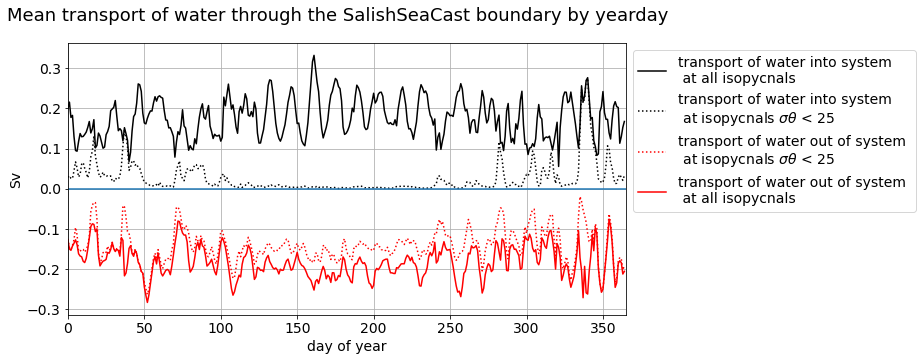

In [14]:
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

fact = 0.5
days = np.arange(0,365,1)
fig, axs = plt.subplots(1,1, figsize=(20*fact, 10*fact), facecolor='w', edgecolor='k')


axs.plot(days,tot_pos_trans/1e6, 'k-', \
            label = 'transport of water into system \n at all isopycnals') 
axs.plot(days,pos_trans_lessthan_sig25/1e6, 'k:', \
            label = 'transport of water into system \n at isopycnals $\sigma$$\\theta$ < 25') 
axs.plot(days,neg_trans_lessthan_sig25/1e6, 'r:',\
           label = 'transport of water out of system \n at isopycnals $\sigma$$\\theta$ < 25') 
axs.plot(days,tot_neg_trans/1e6, 'r-',\
           label = 'transport of water out of system \n at all isopycnals')
axs.axhline(y=0)
axs.grid()
axs.legend(bbox_to_anchor = [1, 1])
axs.set_xlim([0,365])
axs.set_ylabel('Sv')
axs.set_xlabel('day of year')
plt.suptitle('Mean transport of water through the SalishSeaCast boundary by yearday', fontsize = 18)

In [15]:
np.sum(pos_trans_lessthan_sig25)/np.sum(tot_pos_trans)

0.14759817180644552

# JS

In [16]:
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
bcind = 887
mask_bdy = w['vmask'][0,:,bcind,41:71]
print(np.shape(mask_bdy))


w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(w['e2t'][0,375:470,10])

boundary_xs = w['e1t'][0,bcind,41:71]
depths = w['gdept_1d'][:]
#print(w['e3t_1d'][0])
area = np.zeros([40,30])
xdir = np.zeros([40,30])
zdir = np.zeros([40,30])
for i in range(0,40):
    zdir[i,:]=w['e3t_1d'][0,i]
for i in range(0,30):
    xdir[:,i]=boundary_xs[i]
    
area = xdir * zdir

w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
# mask_bdy = w['umask'][0,:,375:470,10]

days = ['0101','0201','0301','0401','0501','0601','0701','0801','0901','1001','1101','1201']
#w1 = nc.Dataset(f'/data/tjarniko/results/BASERUN_EXP/PI5/ncs/{tf}')
day1ofmonth_velocities_PI5 = np.zeros([365,40,30])
day1ofmonth_transports_PI5 = np.zeros([365,40,30])
### get 

UVEL_JS = np.zeros([365,40,30])
s = time.time()
for i in range(0,365):
    if i%10 == 0:
        print(i)
    tdate = arrow_array[i][0]
    ymd = tdate.format('YYYYMMDD')
    
    w = f'/data/tjarniko/results/BASERUN_EXP/PI5/ncs/SKOG_1d_*_grid_V_2015*{ymd}.nc'
    w2 = glob.glob(w)
    tdat = nc.Dataset(w2[0])
    #print(tdat)
    VVEL = tdat['vomecrty'][0,:,bcind,41:71]
    day1ofmonth_velocities_PI5[i,:,:] = VVEL
    day1ofmonth_transports_PI5[i,:,:] = VVEL*area

(40, 30)
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360


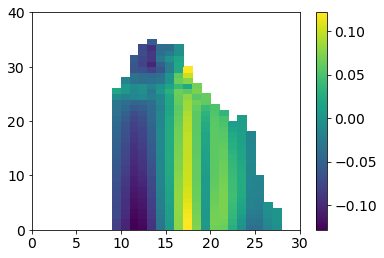

In [17]:
ttest = day1ofmonth_velocities_PI5[0,:,:]
ttest[ttest == 0] = np.nan
plt.pcolormesh(ttest)
plt.colorbar()

In [57]:
np.shape(day1ofmonth_transports_PI5)

pos_JS_transport = np.copy(day1ofmonth_transports_PI5)
pos_JS_transport[pos_JS_transport<0] = 0
neg_JS_transport = np.copy(day1ofmonth_transports_PI5)
neg_JS_transport[neg_JS_transport>0] = 0

pos_JS_sum = np.zeros([365])
neg_JS_sum = np.zeros([365])

for i in range(0,365):
    pos_JS_sum[i] = np.nansum(pos_JS_transport[i,:,:])
    neg_JS_sum[i] = np.nansum(neg_JS_transport[i,:,:])
    
JS_sum_inward = -1 * neg_JS_sum
JS_sum_outward = -1*pos_JS_sum

Text(0.5, 0.98, 'Mean transport of water through the Johnstone Strait boundary by yearday')

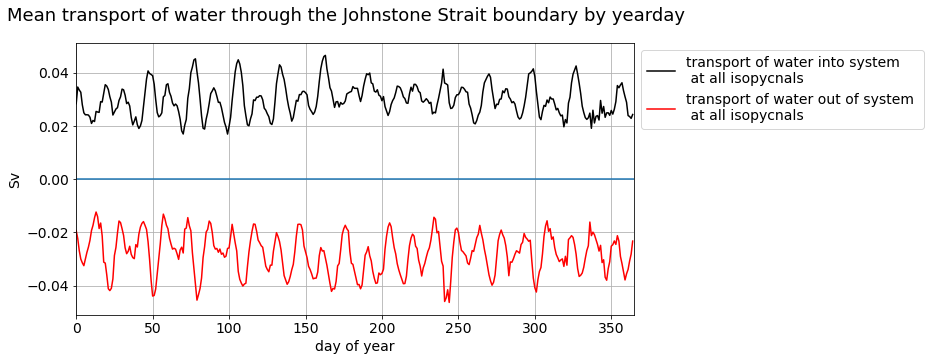

In [59]:
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

fact = 0.5
days = np.arange(0,365,1)
fig, axs = plt.subplots(1,1, figsize=(20*fact, 10*fact), facecolor='w', edgecolor='k')


axs.plot(days,JS_sum_inward/1e6, 'k-', \
            label = 'transport of water into system \n at all isopycnals') 
# axs.plot(days,pos_trans_lessthan_sig25/1e6, 'k:', \
#             label = 'transport of water into system \n at isopycnals $\sigma$$\\theta$ < 25') 
# axs.plot(days,neg_trans_lessthan_sig25/1e6, 'r:',\
#            label = 'transport of water out of system \n at isopycnals $\sigma$$\\theta$ < 25') 
axs.plot(days,JS_sum_outward/1e6, 'r-',\
           label = 'transport of water out of system \n at all isopycnals')
axs.axhline(y=0)
axs.grid()
axs.legend(bbox_to_anchor = [1, 1])
axs.set_xlim([0,365])
axs.set_ylabel('Sv')
axs.set_xlabel('day of year')
plt.suptitle('Mean transport of water through the Johnstone Strait boundary by yearday', fontsize = 18)

Text(0.5, 0.98, 'Mean transport of water through the SalishSeaCast boundaries by yearday')

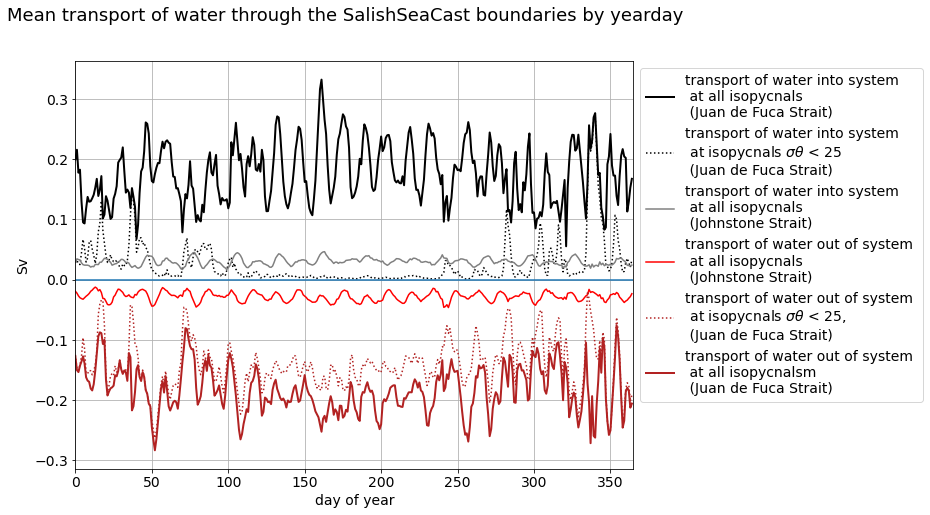

In [60]:
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

fact = 0.5
days = np.arange(0,365,1)
fig, axs = plt.subplots(1,1, figsize=(20*fact, 15*fact), facecolor='w', edgecolor='k')


axs.plot(days,tot_pos_trans/1e6, 'k-', linewidth = 2, \
            label = 'transport of water into system \n at all isopycnals \n (Juan de Fuca Strait)') 
axs.plot(days,pos_trans_lessthan_sig25/1e6, 'k:', \
            label = 'transport of water into system \n at isopycnals $\sigma$$\\theta$ < 25 \n (Juan de Fuca Strait)') 
axs.plot(days,JS_sum_inward/1e6, color = 'grey', linestyle = '-', \
            label = 'transport of water into system \n at all isopycnals \n (Johnstone Strait)') 

axs.plot(days,JS_sum_outward/1e6, color = 'red', linestyle = '-', \
            label = 'transport of water out of system \n at all isopycnals \n (Johnstone Strait)') 

axs.plot(days,neg_trans_lessthan_sig25/1e6, color = 'firebrick', linestyle = ':',\
           label = 'transport of water out of system \n at isopycnals $\sigma$$\\theta$ < 25, \n (Juan de Fuca Strait)') 
axs.plot(days,tot_neg_trans/1e6, color = 'firebrick', linewidth = 2, \
           label = 'transport of water out of system \n at all isopycnalsm \n (Juan de Fuca Strait)')
axs.axhline(y=0)
axs.grid()
axs.legend(bbox_to_anchor = [1, 1])
axs.set_xlim([0,365])
axs.set_ylabel('Sv')
axs.set_xlabel('day of year')
plt.suptitle('Mean transport of water through the SalishSeaCast boundaries by yearday', fontsize = 18)

In [21]:
np.sum(neg_JS_sum)/np.sum(tot_pos_trans)

-0.16967496122604392

In [65]:
print(f'mean pos (inward) transport, JDF, Sv: {np.nanmean(tot_pos_trans)/1e6}')
print(f'mean neg (outward) transport, JDF, : {np.nanmean(tot_neg_trans)/1e6}')
print(f'mean pos transport, JS, Sv: {np.nanmean(JS_sum_inward)/1e6}')
print(f'mean neg transport, JS, : {np.nanmean(JS_sum_outward)/1e6}')


print()
print(f'mean pos transport, JDF+JS, Sv: {np.nanmean(tot_pos_trans+JS_sum_inward)/1e6}')
print(f'mean neg transport, JDF+JS, : {np.nanmean(tot_neg_trans+JS_sum_outward)/1e6}')
# print((np.nanmean(tot_pos_trans)+np.nanmean(tot_neg_trans)+\
#       np.nanmean(pos_JS_sum)+np.nanmean(neg_JS_sum))/1e6)
print(f'total mean transp (out): {np.sum(tot_pos_trans+tot_neg_trans+JS_sum_inward+JS_sum_outward)/1e6/365}')

print()
print(f'total mean transport in via rivers (Sv) {(3684.9115288597663+3548.8770919476597)/1e6})')

print(f'diff between transp in and out: {0.007233788620807426-0.00397947957495884}' )
print(f'the above diff as % of mean neg transp: {(0.0032543090458485857/-0.21167135560317035)*100}')

print()
print('breakdown of transport in (rivers)')
print('Fraser mean flow vol. (yr 2015) calc. at: RIVER_PAPER/not_checked/Fraser_flowvolume.ipynb')
print(f'3684.9115288597663 m3/s or {3684.9115288597663/1e6} Sv')
print(f'non-fraser flow vol calc at RIVER_PAPER/maps_rivers_modeldisc.ipynb')
print(f'3548.877 m3/s or {3548.8770919476597/1e6} Sv')


mean pos (inward) transport, JDF, Sv: 0.17593382036495012
mean neg (outward) transport, JDF, : -0.18181979145439764
mean pos transport, JS, Sv: 0.029851564148772686
mean neg transport, JS, : -0.027945072634283984

mean pos transport, JDF+JS, Sv: 0.2057853845137228
mean neg transport, JDF+JS, : -0.2097648640886816
total mean transp (out): -0.00397947957495884

total mean transport in via rivers (Sv) 0.007233788620807426)
diff between transp in and out: 0.0032543090458485857
the above diff as % of mean neg transp: -1.537434782602131

breakdown of transport in (rivers)
Fraser mean flow vol. (yr 2015) calc. at: RIVER_PAPER/not_checked/Fraser_flowvolume.ipynb
3684.9115288597663 m3/s or 0.0036849115288597662 Sv
non-fraser flow vol calc at RIVER_PAPER/maps_rivers_modeldisc.ipynb
3548.877 m3/s or 0.0035488770919476598 Sv
